In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tarfile
import tensorflow as tf
import time
import xml.etree.ElementTree as ET

from glob import glob
from PIL import Image
from tensorflow.keras import applications, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


In [ ]:
# ===============================
# Step 0.1: Define Constants
# ===============================

pictures_dir = './pictures'
data_root = './data'
models_dir = './models'

images_tar_url = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz'
annotations_tar_url = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz'

images_tar_path = os.path.join(data_root, 'images.tar.gz')
annotations_tar_path = os.path.join(data_root, 'annotations.tar.gz')
images_folder = os.path.join(data_root, 'images')
annotations_folder = os.path.join(data_root, 'annotations')
trimaps_folder = os.path.join(annotations_folder, 'trimaps')

# Create models directory if it doesn't exist
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Create pictures directory if it doesn't exist
if not os.path.exists(pictures_dir):
    os.makedirs(pictures_dir)

# Create data root directory if it doesn't exist
if not os.path.exists(data_root):
    os.makedirs(data_root)

# ===============================
# Step 0.2: ON/OFF Training - Save/Load Model
# ===============================

status_train = True  # Set to False to skip training and load a pre-trained model
status_save_model = status_train
status_load_model = not(status_train)

# ===============================
# Step 0.3: Define Model Parameters
# ===============================

# Random seed for reproducibility
random_seed = 42
# Validation split ratio
validation_split = 0.2
# Image size
IMG_SIZE = (224, 224)

# Learning rate for the optimizer
learning_rate = 1e-4
# Batch size for training
batch_size = 32
# Number of epochs for training
epochs = 50
# Early stopping patience
early_stopping_patience = 5

In [ ]:
# ===============================
# Task 1: Dataset Exploration and Preprocessing
# ===============================

# ===============================
# Step 1: Extract Manually Downloaded Data
# ===============================

# Ensure tar.gz files are downloaded, if not, download them using wget
def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        print(f"Downloading {url} to {dest_path}...")
        os.system(f"wget {url} -O {dest_path}")
        print("Download complete.")
    else:
        print(f"{dest_path} already exists. Skipping download.")

# Extract tar.gz files if necessaryecessary
def extract_if_needed(tar_path, extract_to):
    if not os.path.exists(extract_to):
        print(f"Extracting {tar_path} to {extract_to}...")
        with tarfile.open(tar_path, 'r:gz') as tar:
            tar.extractall(path=data_root)
        print("Done.")
    else:
        print(f"{extract_to} already exists. Skipping extraction.")

# Download tar.gz files if they do not exist
download_file(images_tar_url, images_tar_path)
download_file(annotations_tar_url, annotations_tar_path)

# Ensure tar.gz files exist
assert os.path.exists(images_tar_path), f"{images_tar_path} not found"
assert os.path.exists(annotations_tar_path), f"{annotations_tar_path} not found"

# Extract
extract_if_needed(images_tar_path, images_folder)
extract_if_needed(annotations_tar_path, annotations_folder)


./data\images already exists. Skipping extraction.
./data\annotations already exists. Skipping extraction.


In [4]:
# ===============================
# Step 2: Load Filepaths and Split Dataset
# ===============================

# List all image filenames (without extension)
image_paths = sorted(glob(os.path.join(images_folder, '*.jpg')))
all_ids = [os.path.splitext(os.path.basename(p))[0] for p in image_paths]

# Filter out IDs without corresponding XML
valid_ids = [id_ for id_ in all_ids if os.path.exists(os.path.join(annotations_folder, 'xmls', id_ + '.xml'))]

# Shuffle and split
random.seed(random_seed)
random.shuffle(valid_ids)
split_idx = int(len(valid_ids) * (1 - validation_split))
train_ids = valid_ids[:split_idx]
val_ids = valid_ids[split_idx:]

# Print dataset sizes
print("Total valid images with XML:", len(valid_ids))
print("Train:", len(train_ids))
print("Val:", len(val_ids))

Total valid images with XML: 3686
Train: 2948
Val: 738


In [5]:
# ===============================
# Step 3: Define Preprocessing Function
# ===============================

def load_and_preprocess(id_):
    # Load image
    img_path = os.path.join(images_folder, id_ + '.jpg')
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Load segmentation mask
    mask_path = os.path.join(trimaps_folder, id_ + '.png')
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask > 1, tf.float32)  # Convert trimap to binary mask (foreground = 1)

    return img, mask

In [6]:
# ===============================
# Step 4: Create tf.data.Datasets
# ===============================

def load_and_preprocess_py(id_):
    # Convert bytes tensor to string
    id_str = id_.numpy().decode('utf-8')

    # Load image
    img_path = os.path.join(images_folder, id_str + '.jpg')
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Load mask
    mask_path = os.path.join(trimaps_folder, id_str + '.png')
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask > 1, tf.float32)

    return img, mask

def tf_wrapper(id_):
    img, mask = tf.py_function(
        func=load_and_preprocess_py,
        inp=[id_],
        Tout=[tf.float32, tf.float32]
    )
    img.set_shape([*IMG_SIZE, 3])
    mask.set_shape([*IMG_SIZE, 1])
    return img, mask

def create_dataset(id_list):
    dataset = tf.data.Dataset.from_tensor_slices(id_list)
    dataset = dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_ids)
val_ds = create_dataset(val_ids)

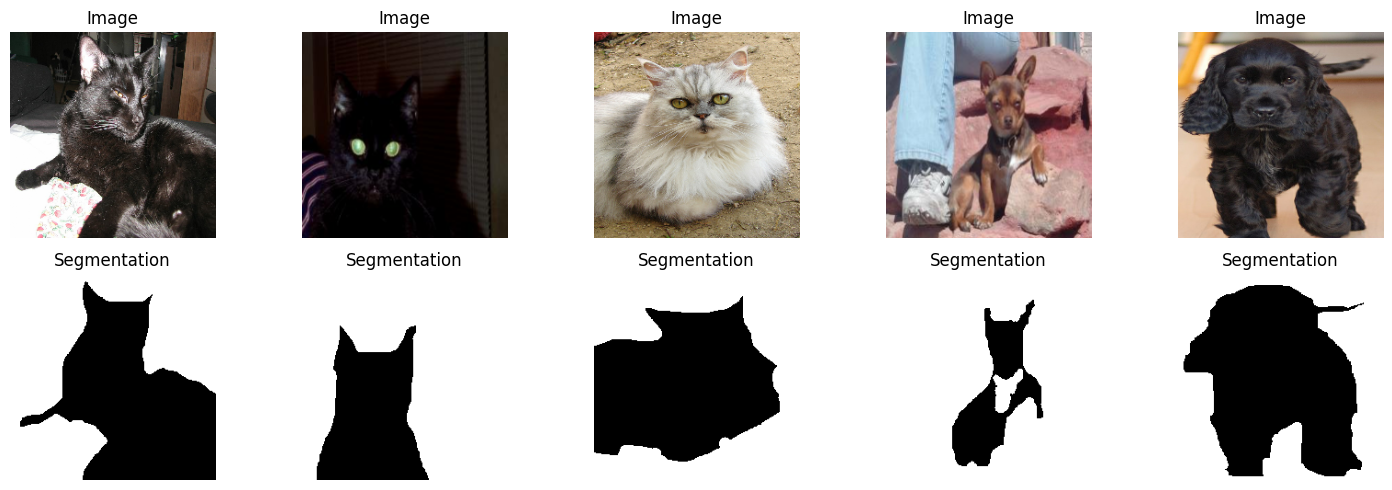

In [ ]:
# ===============================
# Step 5: Visualization
# ===============================

def visualize_batch(dataset, n=5):
    for images, masks in dataset.take(1):
        plt.figure(figsize=(15, 5))
        for i in range(n):
            ax1 = plt.subplot(2, n, i + 1)
            plt.imshow(images[i])
            plt.title("Image")
            plt.axis("off")

            ax2 = plt.subplot(2, n, n + i + 1)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Segmentation")
            plt.axis("off")
        plt.tight_layout()
        plt.savefig(os.path.join(pictures_dir, 'train_sample.png'),dpi=300)
        plt.show()
        

visualize_batch(train_ds)


In [8]:
# ===============================
# Task 2: Object Detection
# ===============================

# ===============================
# Step 1: Read bounding boxes from XML files
# ===============================
# Parse XML annotation to extract bounding box in [cx, cy, w, h] format, normalized to image size.

def parse_bounding_box(xml_path, image_width, image_height):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    obj = root.find("object")
    bbox = obj.find("bndbox")

    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)

    cx = (xmin + xmax) / 2 / image_width
    cy = (ymin + ymax) / 2 / image_height
    w = (xmax - xmin) / image_width
    h = (ymax - ymin) / image_height

    return [cx, cy, w, h]

In [9]:
# ===============================
# Step 2: Load and preprocess image with bounding box
# ===============================
# Read image and its corresponding bounding box, resize image and normalize bbox coordinates.

def load_and_preprocess_detection_py(id_):
    try:
        id_str = id_.numpy().decode('utf-8')

        img_path = os.path.join(images_folder, id_str + '.jpg')
        xml_path = os.path.join(annotations_folder, 'xmls', id_str + '.xml')

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
        if not os.path.exists(xml_path):
            raise FileNotFoundError(f"XML file not found: {xml_path}")

        # Use PIL to get original image size
        with Image.open(img_path) as img_pil:
            orig_width, orig_height = img_pil.size

        # Load image with TensorFlow
        img_raw = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0

        # Parse bbox based on original image size
        bbox = parse_bounding_box(xml_path, orig_width, orig_height)
        bbox = tf.convert_to_tensor(bbox, dtype=tf.float32)

        return img, bbox

    except Exception as e:
        print(f"Error processing ID: {id_str}")
        raise e

In [10]:
# ===============================
# Step 3: Create tf.data.Dataset for object detection
# ===============================
# Build a dataset pipeline using tf.py_function to map image IDs to image and bbox pairs.

def tf_wrapper_detection(id_):
    img, bbox = tf.py_function(
        func=load_and_preprocess_detection_py,
        inp=[id_],
        Tout=[tf.float32, tf.float32]
    )
    img.set_shape([*IMG_SIZE, 3])
    bbox.set_shape([4])
    return img, bbox

def create_detection_dataset(id_list):
    dataset = tf.data.Dataset.from_tensor_slices(id_list)
    dataset = dataset.map(tf_wrapper_detection, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

train_det_ds = create_detection_dataset(train_ids)
val_det_ds = create_detection_dataset(val_ids)


In [11]:
# ===============================
# Step 4: Build detection model with backbone
# ===============================
# Build a CNN model with a backbone (e.g., MobileNetV2) and a dense regression head for bounding boxes.

def build_detection_model(pretrained=True):
    base_model = applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet' if pretrained else None
    )
    base_model.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    bbox_output = layers.Dense(4, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=bbox_output)
    return model


In [12]:
# ===============================
# Step 4.1: Show sample shape
# ===============================

for img, bbox in train_det_ds.take(1):
    print("Sample shape:", img.shape, bbox.shape)

Sample shape: (32, 224, 224, 3) (32, 4)


In [ ]:
# ===============================
# Step 5: Train the object detection model
# ===============================
# Compile and train the model with Mean Squared Error loss and early stopping callbacks.
if status_train:

    model = build_detection_model(pretrained=True)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError(),
        metrics=['mae']
    )

    callbacks = [
        EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(patience=early_stopping_patience-2, factor=0.5)
    ]

    history = model.fit(
        train_det_ds,
        validation_data=val_det_ds,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks
    )


Epoch 1/50
93/93 [==============================] - 30s 226ms/step - loss: 0.0177 - mae: 0.1022 - val_loss: 0.0323 - val_mae: 0.1430 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 16s 175ms/step - loss: 0.0047 - mae: 0.0530 - val_loss: 0.0249 - val_mae: 0.1251 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 17s 178ms/step - loss: 0.0017 - mae: 0.0315 - val_loss: 0.0203 - val_mae: 0.1118 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 17s 179ms/step - loss: 8.7437e-04 - mae: 0.0230 - val_loss: 0.0170 - val_mae: 0.1013 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 16s 170ms/step - loss: 9.9945e-04 - mae: 0.0249 - val_loss: 0.0157 - val_mae: 0.0975 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 16s 173ms/step - loss: 0.0019 - mae: 0.0339 - val_loss: 0.0156 - val_mae: 0.0982 - lr: 1.0000e-04
Epoch 7/50
93/93 [==============================] - 16s 173ms/step - loss: 0.0028 - mae: 0.0

In [ ]:
# ===============================
# Step 5.1: Save the trained model to HDF5 (.h5) format in models directory and training history
# ===============================
object_detector_model_path = os.path.join(models_dir, 'object_detector.h5')
object_detector_history_path = os.path.join(models_dir, 'training_history.json')
if status_load_model:
    if os.path.exists(object_detector_model_path):
        model = load_model(object_detector_model_path)
        print(f"Model loaded from {object_detector_model_path}")
    else:
        raise FileNotFoundError(f"Model file not found: {object_detector_model_path}")

    if os.path.exists(object_detector_history_path):
        with open(object_detector_history_path, 'r') as f:
            history = json.load(f)
        print(f"Training history loaded from {object_detector_history_path}")
    else:
        raise FileNotFoundError(f"Training history file not found: {object_detector_history_path}")


Model saved to 'models/object_detector.h5'
Training history saved to 'models/training_history.json'


In [ ]:
# ===============================
# Step 5.2: Load a trained model from HDF5 file (optional)
# ===============================
if status_load_model:
    model = load_model(object_detector_model_path)
    print(f"Model loaded from {object_detector_model_path}")

    with open(object_detector_history_path, 'r') as f:
        history = json.load(f)
    print(f"Training history loaded from {object_detector_history_path}")

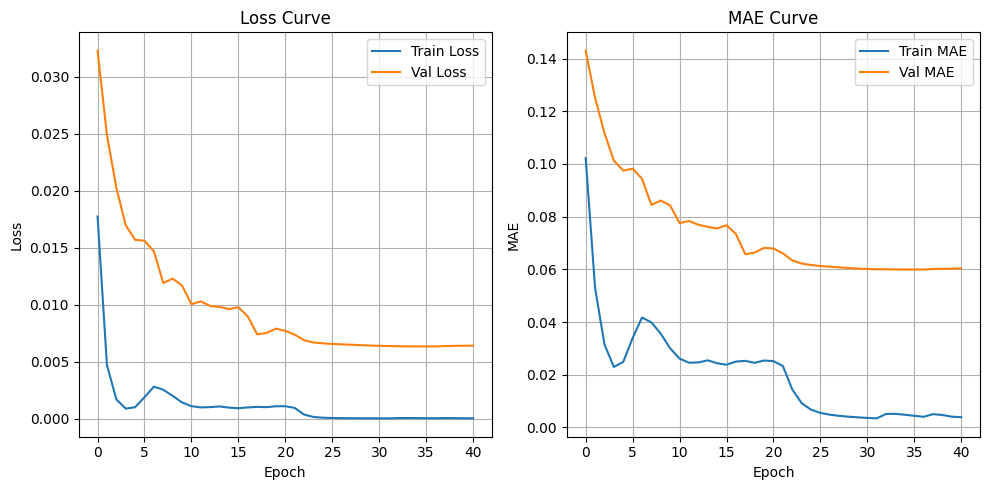

In [ ]:
# ===============================
# Step 5.3: Plot training and validation curves
# ===============================

plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(pictures_dir, 'training_curves.png'),dpi=300)
plt.show()


In [17]:
# ===============================
# Step 6: Visualize predicted and true bounding boxes
# ===============================
# Draw predicted and true bounding boxes on images for visual evaluation.

def display_bbox(image, true_bbox, pred_bbox):
    h, w = IMG_SIZE

    def denormalize(bbox):
        cx, cy, bw, bh = bbox
        xmin = int((cx - bw / 2) * w)
        ymin = int((cy - bh / 2) * h)
        xmax = int((cx + bw / 2) * w)
        ymax = int((cy + bh / 2) * h)
        return xmin, ymin, xmax, ymax

    fig, ax = plt.subplots()
    ax.imshow(image)
    xmin, ymin, xmax, ymax = denormalize(true_bbox)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='green', fill=False, lw=2, label='Ground Truth'))

    xmin, ymin, xmax, ymax = denormalize(pred_bbox)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', fill=False, lw=2, label='Prediction'))
    plt.legend()
    plt.savefig(os.path.join(pictures_dir, 'bbox_comparison.png'))
    plt.show()


In [18]:
# ===============================
# Step 7: Train and compare pretrained vs non-pretrained models
# ===============================
# Train two versions of the model and compare performance (MAE, loss, training time, early stopping)

def train_and_evaluate(pretrained=True):
    print(f"Training model with pretrained={pretrained}")
    model = build_detection_model(pretrained=pretrained)
    model.compile(optimizer=Adam(learning_rate), loss=MeanSquaredError(), metrics=['mae'])

    callbacks = [
        EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(patience=early_stopping_patience-2, factor=0.5)
    ]

    start_time = time.time()
    history = model.fit(
        train_det_ds,
        validation_data=val_det_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    duration = time.time() - start_time

    print(f"Training time: {duration:.2f} seconds")
    return model, history, duration

# Train both models
if status_train:
    model_pretrained, history_pre, time_pre = train_and_evaluate(pretrained=True)
    model_scratch, history_scratch, time_scratch = train_and_evaluate(pretrained=False)


Training model with pretrained=True
Epoch 1/50
93/93 [==============================] - 20s 177ms/step - loss: 0.0186 - mae: 0.1050 - val_loss: 0.0290 - val_mae: 0.1323 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 16s 176ms/step - loss: 0.0052 - mae: 0.0556 - val_loss: 0.0214 - val_mae: 0.1124 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 17s 181ms/step - loss: 0.0019 - mae: 0.0336 - val_loss: 0.0172 - val_mae: 0.1008 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 17s 180ms/step - loss: 0.0010 - mae: 0.0248 - val_loss: 0.0160 - val_mae: 0.0969 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 17s 182ms/step - loss: 9.8931e-04 - mae: 0.0245 - val_loss: 0.0151 - val_mae: 0.0945 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 17s 178ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 0.0132 - val_mae: 0.0884 - lr: 1.0000e-04
Epoch 7/50
93/93 [==============================] - 16s 175m

In [ ]:
# ===============================
# Step 7.1: Save both trained models to HDF5 (.h5) format and training histories
# ===============================

object_detector_pretrained_path = os.path.join(models_dir, 'object_detector_pretrained.h5')
object_detector_scratch_path = os.path.join(models_dir, 'object_detector_scratch.h5')
object_detector_history_pretrained_path = os.path.join(models_dir, 'training_history_pretrained.json')
object_detector_history_scratch_path = os.path.join(models_dir, 'training_history_scratch.json')


if status_save_model:
    model_pretrained.save(object_detector_pretrained_path)
    print(f"Saved: {object_detector_pretrained_path}")

    model_scratch.save(object_detector_scratch_path)
    print(f"Saved: {object_detector_scratch_path}")

    history_pre_clean = {k: [float(v) for v in vals] for k, vals in history_pre.history.items()}
    history_scratch_clean = {k: [float(v) for v in vals] for k, vals in history_scratch.history.items()}

    with open(object_detector_history_pretrained_path, "w") as f:
        json.dump(history_pre_clean, f)
    print(f"Saved: {object_detector_history_pretrained_path}")

    with open(object_detector_history_scratch_path, "w") as f:
        json.dump(history_scratch_clean, f)
    print(f"Saved: {object_detector_history_scratch_path}")


Saved: models/object_detector_pretrained.h5
Saved: models/object_detector_scratch.h5
Saved: models/training_history_pretrained.json
Saved: models/training_history_scratch.json


In [ ]:
# ===============================
# Step 7.3 : Load both trained models from HDF5 files
# ===============================
if status_load_model:

    model_pretrained = load_model(object_detector_pretrained_path)
    model_scratch = load_model(object_detector_scratch_path)

    print(f"Model loaded from {object_detector_pretrained_path}")
    print(f"Model loaded from {object_detector_scratch_path}")

    with open(object_detector_history_pretrained_path, 'r') as f:
        history_pre = json.load(f)
    with open(object_detector_history_scratch_path, 'r') as f:
        history_scratch = json.load(f)
        
    print(f"Training history loaded from {object_detector_history_pretrained_path}")
    print(f"Training history loaded from {object_detector_history_scratch_path}")

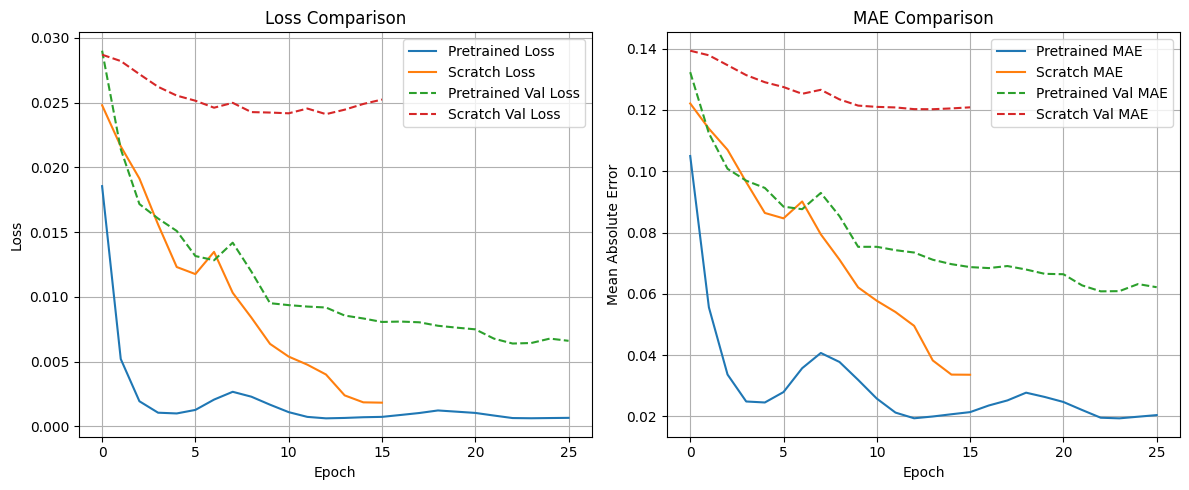

In [ ]:
# ===============================
# Step 7.4: Visualize training and validation loss and MAE for both models
# ===============================

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_pre.history['loss'], label='Pretrained Loss')
plt.plot(history_scratch.history['loss'], label='Scratch Loss')
plt.plot(history_pre.history['val_loss'], label='Pretrained Val Loss', linestyle='--')
plt.plot(history_scratch.history['val_loss'], label='Scratch Val Loss', linestyle='--')
plt.title("Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_pre.history['mae'], label='Pretrained MAE')
plt.plot(history_scratch.history['mae'], label='Scratch MAE')
plt.plot(history_pre.history['val_mae'], label='Pretrained Val MAE', linestyle='--')
plt.plot(history_scratch.history['val_mae'], label='Scratch Val MAE', linestyle='--')
plt.title("MAE Comparison")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(pictures_dir, 'model_comparison_curves.png'),dpi=300)
plt.show()


In [22]:
# ===============================
# Step 8: Compute Intersection over Union (IoU)
# ===============================
# Compute IoU between predicted and true bounding boxes for visual examples

def compute_iou(box1, box2):
    def denorm(bbox):
        cx, cy, w, h = bbox
        xmin = cx - w / 2
        ymin = cy - h / 2
        xmax = cx + w / 2
        ymax = cy + h / 2
        return [xmin, ymin, xmax, ymax]

    box1 = denorm(box1)
    box2 = denorm(box2)

    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou


1/1 [==============================] - 1s 593ms/step
IoU Score: 0.692


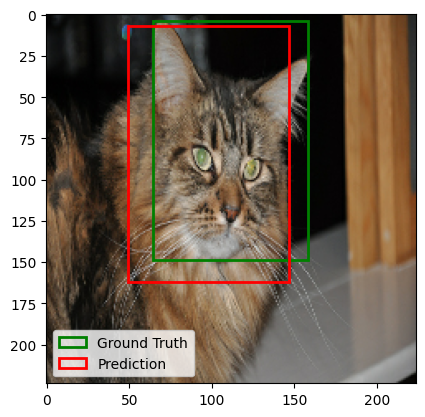

IoU Score: 0.121


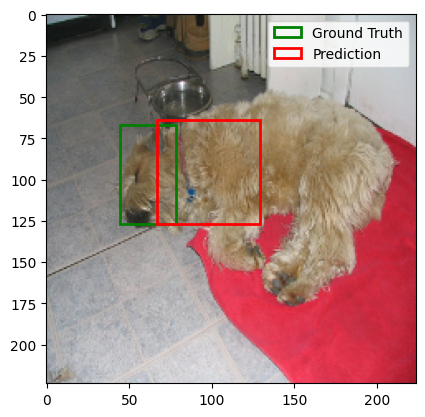

IoU Score: 0.153


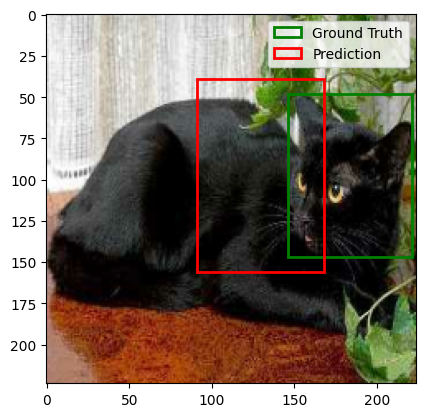

1/1 [==============================] - 1s 531ms/step
IoU Score: 0.545


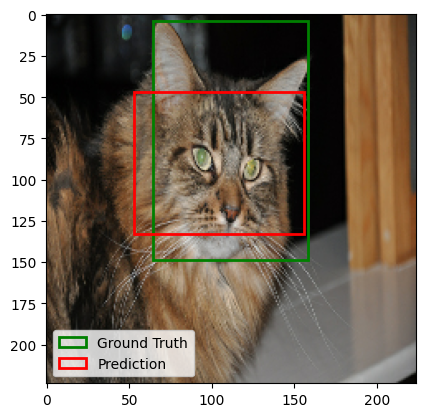

IoU Score: 0.156


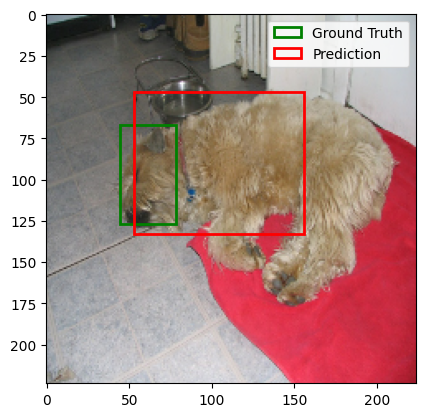

IoU Score: 0.058


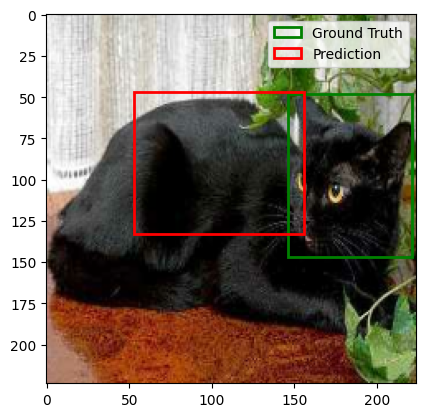

In [23]:
# ===============================
# Step 9: Visualize predictions and IoU
# ===============================
# Visualize a few predictions from the validation set and display the IoU

def visualize_predictions(model, dataset, n=3):
    for images, bboxes in dataset.take(1):
        preds = model.predict(images)
        for i in range(n):
            img_np = images[i].numpy()
            true_bbox = bboxes[i].numpy()
            pred_bbox = preds[i]

            iou_score = compute_iou(true_bbox, pred_bbox)
            print(f"IoU Score: {iou_score:.3f}")
            display_bbox(img_np, true_bbox, pred_bbox)

# Show prediction results from pretrained model
visualize_predictions(model_pretrained, val_det_ds)
# Show prediction results from scratch model
visualize_predictions(model_scratch, val_det_ds)
# Show prediction results from both models


In [ ]:
# ===============================
# Step 10: Run inference on test images (optional)
# ===============================
# 
# If test images are prepared with bbox, use this step for evaluation

# Example:
# test_det_ds = create_detection_dataset(test_ids)
# visualize_predictions(model_pretrained, test_det_ds)


In [24]:
# ===============================
# Task 3: Semantic Segmentation
# ===============================

# ===============================
# Step 1: Create segmentation datasets from valid IDs
# ===============================

def create_segmentation_dataset(id_list):
    def load_segmentation_py(id_):
        id_str = id_.numpy().decode("utf-8")

        img_path = os.path.join(images_folder, id_str + '.jpg')
        mask_path = os.path.join(trimaps_folder, id_str + '.png')

        # Load and process image
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0

        # Load and process mask (convert trimap to binary)
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
        mask = tf.cast(mask > 1, tf.float32)

        return img, mask

    def tf_wrapper(id_):
        img, mask = tf.py_function(
            func=load_segmentation_py,
            inp=[id_],
            Tout=[tf.float32, tf.float32]
        )
        img.set_shape([*IMG_SIZE, 3])
        mask.set_shape([*IMG_SIZE, 1])
        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices(id_list)
    dataset = dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets
train_seg_ds = create_segmentation_dataset(train_ids)
val_seg_ds = create_segmentation_dataset(val_ids)


In [25]:
# ===============================
# Step 2: Build semantic segmentation model
# ===============================
# Build an encoder-decoder model using MobileNetV2 as the backbone

def build_segmentation_model(pretrained=True):
    base_model = applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet' if pretrained else None
    )
    base_model.trainable = True

    x = base_model.output
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
    output = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=output)
    return model


In [26]:
# ===============================
# Step 3: Train the semantic segmentation model
# ===============================
if status_train:
    model_seg = build_segmentation_model(pretrained=True)

    model_seg.compile(
        optimizer=Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(patience=early_stopping_patience-2, factor=0.5)
    ]

    history_seg = model_seg.fit(
        train_seg_ds,
        validation_data=val_seg_ds,
        epochs=epochs,
        callbacks=callbacks
    )


Epoch 1/50
93/93 [==============================] - 26s 235ms/step - loss: 0.4686 - accuracy: 0.6927 - val_loss: 2.7697 - val_accuracy: 0.6994 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 21s 223ms/step - loss: 0.3087 - accuracy: 0.8458 - val_loss: 3.0413 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 20s 218ms/step - loss: 0.2844 - accuracy: 0.9068 - val_loss: 2.8681 - val_accuracy: 0.7514 - lr: 5.0000e-05
Epoch 4/50
93/93 [==============================] - 21s 223ms/step - loss: 0.2753 - accuracy: 0.9205 - val_loss: 2.4964 - val_accuracy: 0.7749 - lr: 2.5000e-05
Epoch 5/50
93/93 [==============================] - 21s 223ms/step - loss: 0.2704 - accuracy: 0.9266 - val_loss: 2.1473 - val_accuracy: 0.7984 - lr: 2.5000e-05
Epoch 6/50
93/93 [==============================] - 21s 229ms/step - loss: 0.2650 - accuracy: 0.9323 - val_loss: 1.8405 - val_accuracy: 0.8239 - lr: 2.5000e-05
Epoch 7/50
93/93 [======================

In [27]:
# ===============================
# Step 3.1: Save the segmentation model and training history
# ===============================

model_seg_path = os.path.join(models_dir, "segmenter.h5")
history_seg_path = os.path.join(models_dir, "segmentation_log.json")

if status_save_model:
    model_seg.save(model_seg_path)
    print(f"Segmentation model saved to '{model_seg_path}'")

    history_clean = {k: [float(v) for v in vals] for k, vals in history_seg.history.items()}
    with open(history_seg_path, "w") as f:
        json.dump(history_clean, f)
    print(f"Training history saved to '{history_seg_path}'")


Segmentation model saved to './models\segmenter.h5'
Training history saved to './models\segmentation_log.json'


In [ ]:
# ===============================
# Step 3.2: Load segmentation model and history (optional)
# ===============================

if status_load_model:
    model_seg = load_model(model_seg_path)
    print(f"Model loaded from '{model_seg_path}'")

    with open(history_seg_path, "r") as f:
        history_seg = json.load(f)
    print(f"Training history loaded from '{history_seg_path}'")


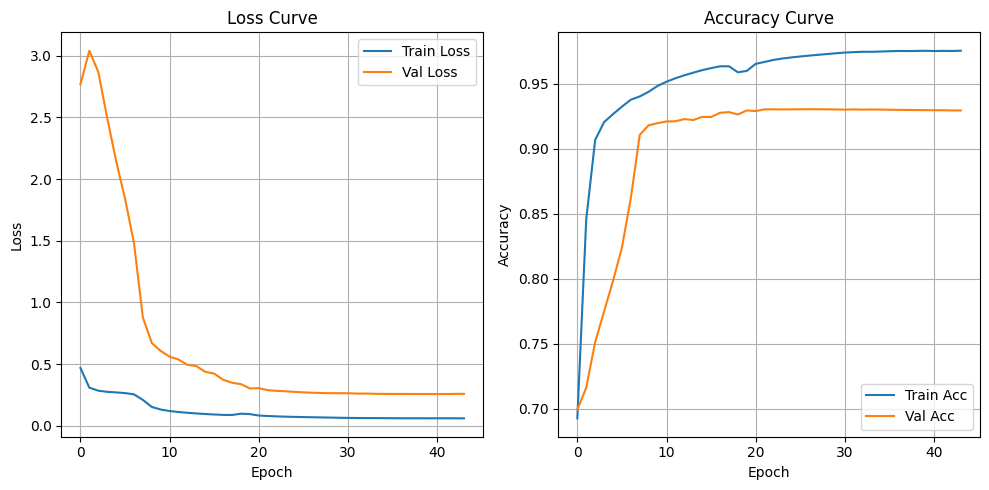

In [33]:
# ===============================
# Step 3.3: Plot training and validation loss and accuracy
# ===============================

plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_seg.history['loss'], label='Train Loss')
plt.plot(history_seg.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_seg.history['accuracy'], label='Train Acc')
plt.plot(history_seg.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(pictures_dir, "segmentation_loss_accuracy.png"), dpi=300)
plt.show()


In [34]:
# ===============================
# Step 4: Train and compare pretrained vs non-pretrained segmentation models
# ===============================

def train_segmentation_variant(pretrained=True):
    model = build_segmentation_model(pretrained=pretrained)
    model.compile(optimizer=Adam(learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(patience=early_stopping_patience-2, factor=0.5)
    ]

    history = model.fit(
        train_seg_ds,
        validation_data=val_seg_ds,
        epochs=epochs,
        callbacks=callbacks
    )

    return model, history

# Train both variants
if  status_train:
    seg_model_pre, seg_hist_pre = train_segmentation_variant(pretrained=True)
    seg_model_scratch, seg_hist_scratch = train_segmentation_variant(pretrained=False)


Epoch 1/50
93/93 [==============================] - 25s 228ms/step - loss: 0.5211 - accuracy: 0.7921 - val_loss: 8.2466 - val_accuracy: 0.7119 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 21s 223ms/step - loss: 0.1931 - accuracy: 0.9222 - val_loss: 5.0412 - val_accuracy: 0.7475 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 21s 226ms/step - loss: 0.1479 - accuracy: 0.9378 - val_loss: 4.3928 - val_accuracy: 0.7574 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 21s 225ms/step - loss: 0.1256 - accuracy: 0.9468 - val_loss: 4.1886 - val_accuracy: 0.7627 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 21s 226ms/step - loss: 0.1115 - accuracy: 0.9527 - val_loss: 3.6247 - val_accuracy: 0.7787 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 22s 232ms/step - loss: 0.1051 - accuracy: 0.9552 - val_loss: 2.9774 - val_accuracy: 0.7940 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [35]:
# ===============================
# Step 4.1: Save both trained segmentation models and histories
# ===============================

seg_model_pre_path = os.path.join(models_dir, "segmenter_pretrained.h5")
seg_model_scratch_path = os.path.join(models_dir, "segmenter_scratch.h5")
seg_hist_pre_path = os.path.join(models_dir, "segmentation_history_pretrained.json")
seg_hist_scratch_path = os.path.join(models_dir, "segmentation_history_scratch.json")

if status_save_model:
    
    seg_model_pre.save(seg_model_pre_path)
    print(f"Pretrained segmentation model saved to '{seg_model_pre_path}'")

    seg_model_scratch.save(seg_model_scratch_path)
    print(f"Scratch segmentation model saved to '{seg_model_scratch_path}'")

    history_pre_clean = {k: [float(v) for v in vals] for k, vals in seg_hist_pre.history.items()}
    history_scratch_clean = {k: [float(v) for v in vals] for k, vals in seg_hist_scratch.history.items()}

    with open(seg_hist_pre_path, "w") as f:
        json.dump(history_pre_clean, f)
    print(f"Pretrained segmentation history saved to '{seg_hist_pre_path}'")

    with open(seg_hist_scratch_path, "w") as f:
        json.dump(history_scratch_clean, f)
    print(f"Scratch segmentation history saved to '{seg_hist_scratch_path}'")


Pretrained segmentation model saved to './models\segmenter_pretrained.h5'
Scratch segmentation model saved to './models\segmenter_scratch.h5'
Pretrained segmentation history saved to './models\segmentation_history_pretrained.json'
Scratch segmentation history saved to './models\segmentation_history_scratch.json'


In [ ]:
# ===============================
# Step 4.2: Load both trained segmentation models and histories
# ===============================

if status_load_model:
    seg_model_pre = load_model(seg_model_pre_path)
    print(f"Pretrained segmentation model loaded from '{seg_model_pre_path}'")

    seg_model_scratch = load_model(seg_model_scratch_path)
    print(f"Scratch segmentation model loaded from '{seg_model_scratch_path}'")

    with open(seg_hist_pre_path, "r") as f:
        seg_hist_pre = json.load(f)
    print(f"Pretrained segmentation history loaded from '{seg_hist_pre_path}'")

    with open(seg_hist_scratch_path, "r") as f:
        seg_hist_scratch = json.load(f)
    print(f"Scratch segmentation history loaded from '{seg_hist_scratch_path}'")


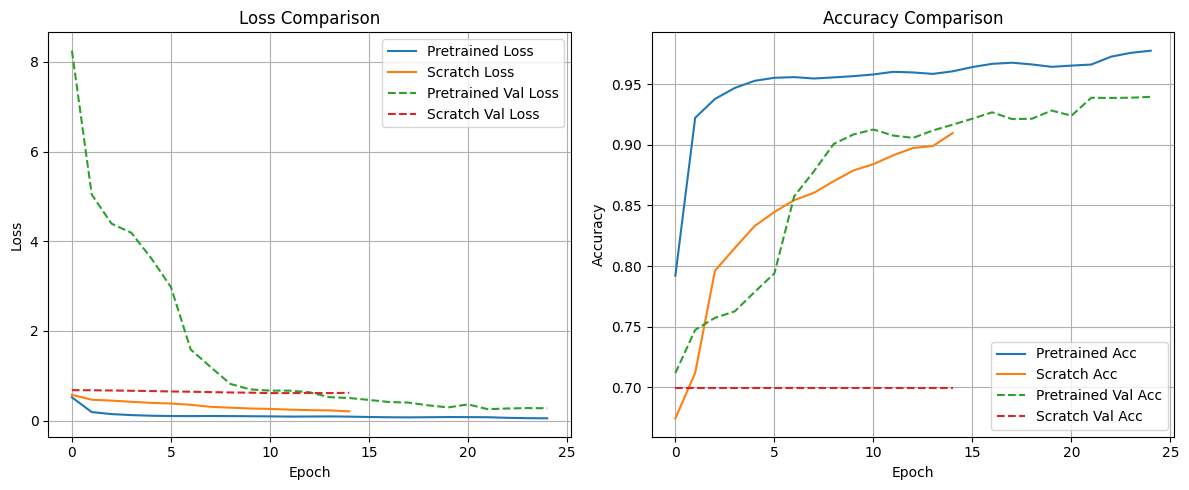

In [36]:
# ===============================
# Step 4.3: Compare pretrained vs scratch (loss and accuracy)
# ===============================

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(seg_hist_pre.history['loss'], label='Pretrained Loss')
plt.plot(seg_hist_scratch.history['loss'], label='Scratch Loss')
plt.plot(seg_hist_pre.history['val_loss'], label='Pretrained Val Loss', linestyle='--')
plt.plot(seg_hist_scratch.history['val_loss'], label='Scratch Val Loss', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(seg_hist_pre.history['accuracy'], label='Pretrained Acc')
plt.plot(seg_hist_scratch.history['accuracy'], label='Scratch Acc')
plt.plot(seg_hist_pre.history['val_accuracy'], label='Pretrained Val Acc', linestyle='--')
plt.plot(seg_hist_scratch.history['val_accuracy'], label='Scratch Val Acc', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(pictures_dir, "segmentation_loss_acc_compare.png"), dpi=300)
plt.show()


1/1 [==============================] - 1s 675ms/step


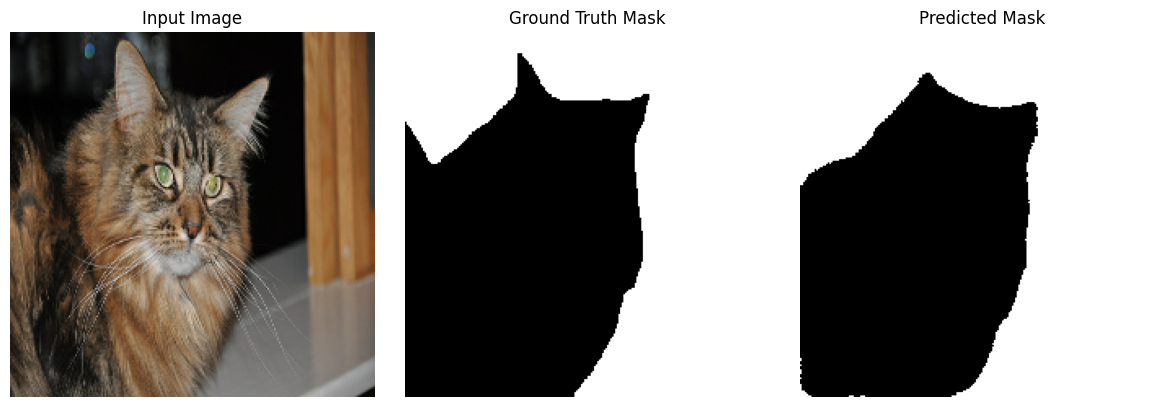

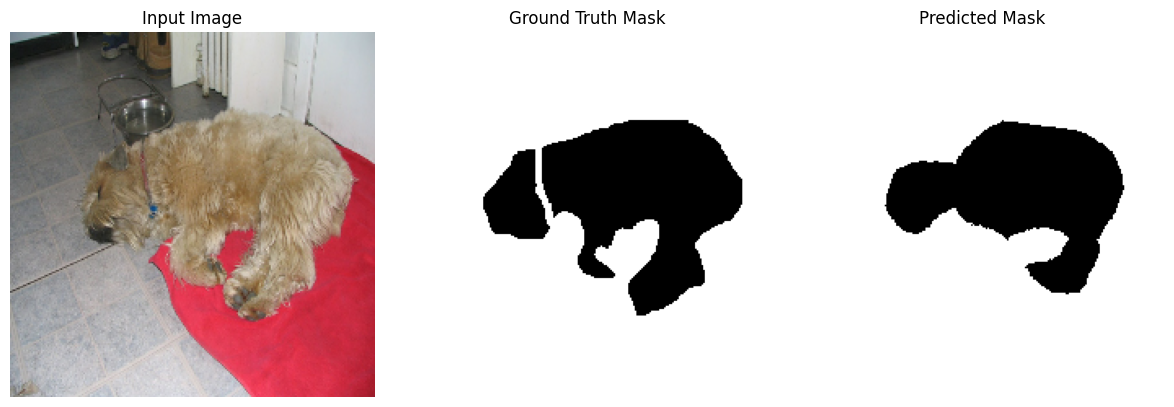

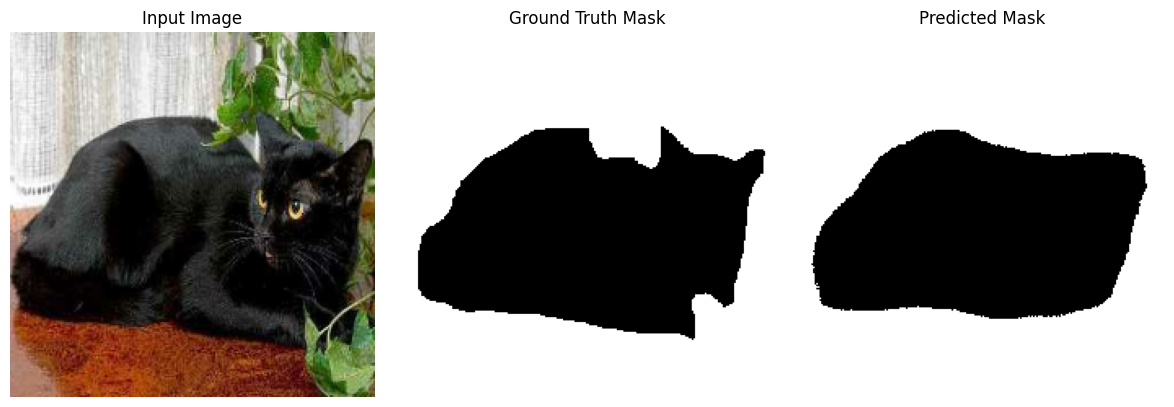

In [37]:
# ===============================
# Step 4.4: Visualize prediction vs ground truth masks
# ===============================

def visualize_segmentation_predictions(model, dataset, n=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(n):
            plt.figure(figsize=(12, 4))

            # Original image
            plt.subplot(1, 3, 1)
            plt.imshow(images[i])
            plt.title("Input Image")
            plt.axis("off")

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis("off")

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(preds[i, :, :, 0] > 0.5, cmap='gray')  # Binarize
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(pictures_dir, f"segmentation_result_{i+1}.png"), dpi=300)
            plt.show()

# Show prediction results from pretrained model
visualize_segmentation_predictions(seg_model_pre, val_seg_ds)


In [ ]:
# ===============================
# Task 4: Multitask Transfer Learning
# ===============================

# ===============================
